## Подготовка

In [1]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import  scipy.signal.signaltools
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
import catboost as cb

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Загружаем данные, сразу указав какой столбец будет индексом, распознав дату

In [3]:
df = pd.read_csv('/content/taxi.csv', index_col=[0], parse_dates=[0])

In [4]:
df = df.sort_index()

In [5]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Проведем ресемплирование по 1 часу

In [6]:
df = df.resample('1H').sum()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [8]:
df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


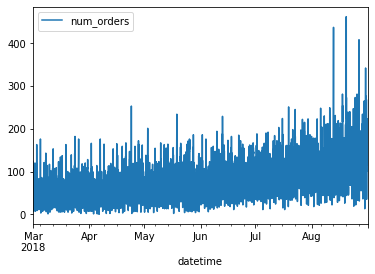

In [9]:
df.plot()

График совсем не презентабельный и не информативный. Далее расширим количетсво признаков и посмотрим более детально на предоставленные данные

## Анализ

Добавим количество признаков

In [10]:
def make_features(table, max_lag, rolling_mean_size):
    new_table = table.copy()
    new_table['month'] = new_table.index.month
    new_table['day'] = new_table.index.day
    new_table['dayofweek'] = new_table.index.dayofweek
    new_table['hour'] = new_table.index.hour
    
    for lag in range(1, max_lag + 1):
        new_table['lag_{}'.format(lag)] = new_table['num_orders'].shift(lag)

    new_table['rolling_mean'] = new_table['num_orders'].shift().rolling(rolling_mean_size).mean()
    return new_table

In [11]:
df_new = make_features(df, 5, 5)

Удалим пропуски

In [12]:
df_new = df_new.dropna()

In [13]:
df_new.head()

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,rolling_mean
datetime,,,,,,,,,,,
2018-03-01 05:00:00,6,3,1,3,5,43.0,66.0,71.0,85.0,124.0,77.8
2018-03-01 06:00:00,12,3,1,3,6,6.0,43.0,66.0,71.0,85.0,54.2
2018-03-01 07:00:00,15,3,1,3,7,12.0,6.0,43.0,66.0,71.0,39.6
2018-03-01 08:00:00,34,3,1,3,8,15.0,12.0,6.0,43.0,66.0,28.4
2018-03-01 09:00:00,69,3,1,3,9,34.0,15.0,12.0,6.0,43.0,22.0


---

Посмотрим есть ли тренды и сезонность в этих данных

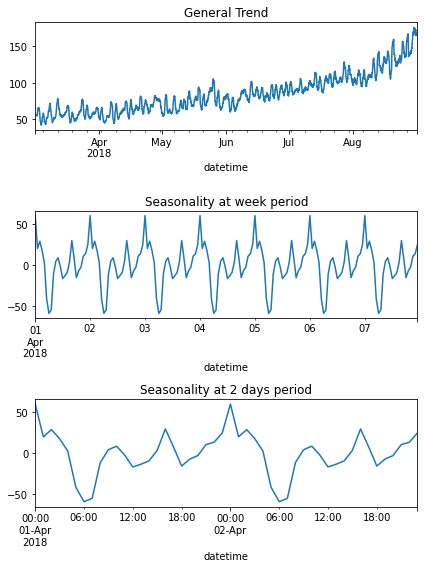

In [14]:
data = df_new['num_orders']
decomposed = seasonal_decompose(data)

plt.figure(figsize=(6, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('General Trend')
plt.subplot(312)
decomposed.seasonal['2018-04-01':'2018-04-07'].plot(ax=plt.gca()) 
plt.title('Seasonality at week period')
plt.subplot(313)
decomposed.seasonal['2018-04-01':'2018-04-02'].plot(ax=plt.gca()) 
plt.title('Seasonality at 2 days period')
plt.tight_layout()

Количество заказов с началом лета увеличивается, что естественно теплое время года благоприятствует туризму. И сезонность ярко выраженная, то есть начиная с 06.00 и до 24.00 количество заказов растет, думаю это связано с подстройкой работы аэропортов под биоритм человека, никто не любит вылетать/прилетать поздней ночью.

---

Посмотрим является ли наши данные стационарным времянным рядом

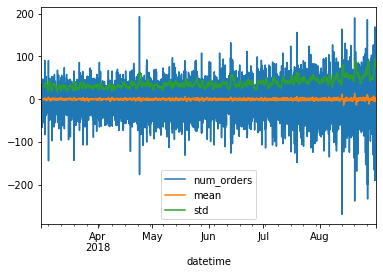

In [15]:
data = df_new - df_new.shift()
data['mean'] = data['num_orders'].rolling(24).mean()
data['std'] = data['num_orders'].rolling(24).std()
data[['num_orders', 'mean', 'std']].plot()

Как видно из графика среднее никак не меняется и предстваляет ровную линию. В правой части графика видно увеличение стандартного отклонения, оно связано с трендом, который мы рассмотрели ранее. Следовательно можно сделать вывод, что наши данные являются стационарным времянным рядом.

### Вывод

Рассмотрели более детально полученные данные убедились в наличии тренда и сезонности в данных, а так же что данные являются стационарным времянным рядом, что значит можно к нему применять мат.аппарат для прогнозирования.

## Обучение

Рассмотрим два алгоритма RandomForest & Catboost. Так как в данных есть категориальные и количественные данные, то для модели случайного леса преобразуем категориальные признаки методом OHE. В Catboost укажем какие признаки являются категориальными.

In [16]:
df_1 = df_new.copy()
df_2 = df_new.copy()

### Подготовка данных

Разделим данные на две выборки для обучения и для тестирования

In [17]:
cat_data = ['month','day', 'dayofweek', 'hour']
num_data = ['lag_1','lag_2', 'lag_3', 'rolling_mean']

In [18]:
df_1 = pd.get_dummies(data=df_1,columns=cat_data, drop_first=True)

In [19]:
train_1, test_1 = train_test_split(df_1, shuffle=False, test_size=0.1)
train_2, test_2 = train_test_split(df_2, shuffle=False, test_size=0.1)
train_1 = train_1.dropna()
train_2 = train_2.dropna()

features_train_1 = train_1.drop(['num_orders'], axis=1)
target_train_1 = train_1['num_orders']
features_test_1 = test_1.drop(['num_orders'], axis=1)
target_test_1 = test_1['num_orders']


features_train_2 = train_2.drop(['num_orders'], axis=1)
target_train_2 = train_2['num_orders']
features_test_2 = test_2.drop(['num_orders'], axis=1)
target_test_2 = test_2['num_orders']

Масштабируем количественные признаки

In [20]:
scaler = StandardScaler()
scaler.fit(features_train_1[num_data]) 
features_train_1[num_data] = scaler.transform(features_train_1[num_data])
features_test_1[num_data] = scaler.transform(features_test_1[num_data])
features_train_2[num_data] = scaler.transform(features_train_2[num_data])
features_test_2[num_data] = scaler.transform(features_test_2[num_data])

### Поиск лучшей модели

Так как у нас временные ряды, то воспользуемся функцией **TimeSeriesSplit()**

In [21]:
tscv = TimeSeriesSplit(n_splits=5)

In [22]:
result_df = pd.DataFrame(columns=['RMSE', 'R2'])
result_df.index.name='name_ml'

In [23]:
%%time
#Время выполнения ячеки около 4 минут
tuned_parameters = {"n_estimators": list(range(80,201,20)), 
                    "max_depth"   : list(range(5,12,1))}

scoring = ('neg_root_mean_squared_error')
rf_model = RandomForestRegressor(random_state=101)

rand_forest = GridSearchCV(rf_model, param_grid=tuned_parameters, scoring=scoring, cv=tscv, n_jobs=-1)
rand_forest.fit(features_train_1, target_train_1)
print("Best parameters set found on development set:")
print(rand_forest.best_params_)
print('')
print('***'*30)
rand_pred = rand_forest.predict(features_test_1)
result_df.loc['RandomForest'] = [round(mean_squared_error(target_test_1, rand_pred, squared=False), 2), 
                                 round(r2_score(target_test_1, rand_pred), 2)]
display(result_df)

Best parameters set found on development set:
{'max_depth': 11, 'n_estimators': 200}

******************************************************************************************


,RMSE,R2
name_ml,,
RandomForest,49.74,0.28


CPU times: user 7.05 s, sys: 293 ms, total: 7.35 s
Wall time: 4min 8s


In [24]:
%%time
#Время выполнения ячеки около 9 минут
tuned_parameters = {'depth'         : list(range(5,12,1)),
                    'iterations'    : list(range(80,201,20))
                   }

cat_model = cb.CatBoostRegressor(random_seed=101, 
                                 early_stopping_rounds=20, 
                                 loss_function = 'RMSE',
                                 cat_features = cat_data,
                                 silent=True)

CBR = GridSearchCV(cat_model, param_grid=tuned_parameters, cv=tscv, n_jobs=-1)
CBR.fit(features_train_2, target_train_2, eval_set=(features_test_2, target_test_2))

print("Best parameters set found on development set:")
print(CBR.best_params_)
print('')
print('***'*30)
cat_pred = CBR.predict(features_test_2)
result_df.loc['CatBoost'] = [round(mean_squared_error(target_test_2, cat_pred, squared=False), 2), 
                                 round(r2_score(target_test_2, cat_pred), 2)]
display(result_df)

Best parameters set found on development set:
{'depth': 5, 'iterations': 120}

******************************************************************************************


,RMSE,R2
name_ml,,
RandomForest,49.74,0.28
CatBoost,41.50,0.50


CPU times: user 4.09 s, sys: 293 ms, total: 4.38 s
Wall time: 4min 36s


### Вывод

Успешно подготовили данные для двух моделей, с помощью метода GridSearchCV удалось подобрать лучшие параметры для двух моделей RandomForest & Catboost

## Тестирование

Проверим наши модели на тестовых данных, и дополнительно сравним с константной моделью, в качестве предсказаний возьмем медиану

In [25]:
# Сформируем перечень моделей, которые будут обучены
models = [
    ('RandomForest', 1, rand_forest.best_estimator_),
    ('CatBoost', 2, CBR.best_estimator_),
    ('Dummy', 1, DummyRegressor(strategy="median"))
]

# Итоговая таблица
results = pd.DataFrame(columns=['RMSE на тесте', 'R2 на тесте'])
results.index.name = 'Модель'

#Таблица для построения графика
df_draw = pd.DataFrame(target_test_1)

# Проведем выбор лучшей модели
for name, data, model in models:
    if data == 1:
        features_train = features_train_1
        target_train = target_train_1
        features_test = features_test_1
        target_test = target_test_1
    else:
        features_train = features_train_2
        target_train = target_train_2
        features_test = features_test_2
        target_test = target_test_2
    
    model.fit(features_train, target_train)
    predict = model.predict(features_test)
    
    results.loc[name]=[mean_squared_error(target_test, predict, squared=False), r2_score(target_test, predict)]
    
    if name == "Dummy": # Сравнения с болванкой
        dummy = DummyRegressor(strategy="median")
        dummy.fit(features_train, target_train)
        predict = dummy.predict(features_test)
        results.loc[name]=[mean_squared_error(target_test, predict, squared=False), r2_score(target_test, predict)]
        
    df_draw[name] = predict.astype('int')

# Выведем результаты
display(results)

,RMSE на тесте,R2 на тесте
Модель,,
RandomForest,49.739663,0.278298
CatBoost,45.357103,0.399874
Dummy,87.152776,-1.215718


Для наглядности на графике отобразим полученные предсказания и реальные данные. Так как рассматриваемый период очень большой для масштаба 1 час, изменим масштаб на 4 часовой.

In [26]:
df_draw = df_draw.resample('4H').sum()

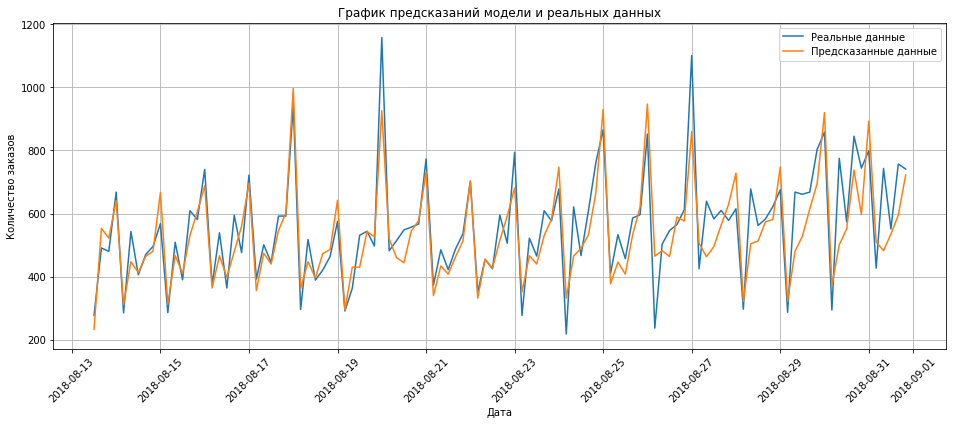

In [27]:
fig, ax = plt.subplots()
fig.set_size_inches(16,6)
ax.plot(df_draw[['num_orders','CatBoost']])

plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.title('График предсказаний модели и реальных данных')

plt.legend(['Реальные данные', 'Предсказанные данные'], frameon=True)
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

## Вывод

Проведен анализ полученых данных, виден четкий тренд и сезонность в данных. С помощью модели Catboost удалось достичь заданных пределов значения метрики **RMSE** 45,35 против требования не более 48. Но при этом у нас получился довольно малое значение $R^2$, это говорит о том, ошибка предсказаний моделью на 40 % меньше, чем ошибка предсказывания средним значением.